In [31]:
import pandahouse as ph
import pandas as pd
import seaborn  as sns
import numpy as np

In [32]:
"""Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите \
количество строк в таблице ldn_listings."""

'Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.'

In [33]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [34]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')



In [35]:
ldn_listings_sql = '''
    SELECT count(*)
FROM default.ldn_listings 


    '''

In [36]:
ldn_listings  = ph.read_clickhouse(query=ldn_listings_sql, connection=connection_default)

In [37]:
ldn_listings 

,count()
0,85207


In [93]:
"""Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы: \
price – цена за ночь, \
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)\
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id\
Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены"""

'Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы: price – цена за ночь, room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию idСгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены'

In [94]:
room_type_price_sql = '''
 SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
    FROM default.ldn_listings
    order by id
    limit 1000

    '''

In [95]:
room_type_price = ph.read_clickhouse(query=room_type_price_sql, connection=connection_default)

In [96]:
room_type_price.groupby('room_type').price.quantile(q=0.75).reset_index()

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [103]:
"""К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). \
В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.\
Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.                                             \
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)                \
2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)"""

'К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.                                             1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)                2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)'

In [104]:
review_scores_rating_sql = '''
    SELECT
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    room_type,
    id,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM default.ldn_listings
    where review_scores_rating is not null
    order by id
    limit 1000
    '''

In [105]:
review_scores_rating = ph.read_clickhouse(query=review_scores_rating_sql, connection=connection_default)

In [106]:
review_scores_rating.head(3)

,price,room_type,id,review_scores_rating
0,65.0,Private room,13913,97.0
1,100.0,Entire home/apt,15400,96.0
2,300.0,Entire home/apt,17402,94.0


In [107]:
review_scores_rating_mean=review_scores_rating.groupby('room_type',as_index=False)\
    .agg({"price":'mean', 'review_scores_rating':'mean'})
review_scores_rating_mean.head(3)

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205


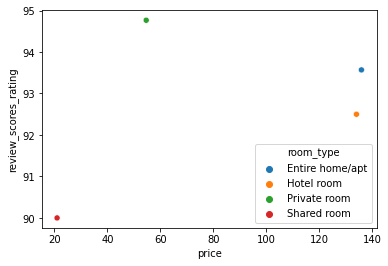

In [108]:
sns.scatterplot(data=review_scores_rating_mean,x='price',y='review_scores_rating',hue='room_type')

In [115]:
"""Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.\
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления \
(experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:\
host_id – идентификатор хозяина (уникальный)\
host_verifications – какими способами хост подтвердил свой профиль\
Затем обработайте столбец host_verifications:\
Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: \
2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации \
Сколько хозяев подтвердили профиль с помощью аккаунта Google?"""

'Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != \'none\'). Для каждого уникального пользователя выгрузите только две колонки:host_id – идентификатор хозяина (уникальный)host_verifications – какими способами хост подтвердил свой профильЗатем обработайте столбец host_verifications:Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации Сколько хозяев подтвердили профиль с помощью аккаунта Google?'

In [116]:
Impression_sql = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
"""

In [117]:
Impression = ph.read_clickhouse(query=Impression_sql, connection=connection_default)

In [118]:
Impression.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [119]:
Impression.host_verifications.apply(lambda x: x.strip('[]').replace("'", '').split(','))\
    .explode().value_counts()\
    .to_frame()
#google	34

,host_verifications
email,1345
phone,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


In [128]:
"""Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. \
Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. \
Новый столбец назовите experiences_count.\
Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. \
Затем преобразуйте данные с помощью pivot, поместив в индексы название района,столбцы – вид впечатления, \
а значения – число объявлений с таким впечатлением для каждого района. \
Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True)."""

'Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района,столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).'

In [129]:
experiences_sql = """
SELECT
    experiences_offered,
    neighbourhood_cleansed,
    count(experiences_offered) as experiences_count 
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
group by neighbourhood_cleansed, experiences_offered
order by experiences_count desc
limit 100
    """

In [130]:
experiences = ph.read_clickhouse(query=experiences_sql, connection=connection_default)

In [131]:
experiences.head(3)

,experiences_offered,neighbourhood_cleansed,experiences_count
0,family,Hackney,61
1,business,Tower Hamlets,58
2,business,Westminster,50


In [132]:
experiences_offered=experiences.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count').fillna(0)
experiences_offered.head(3)

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0


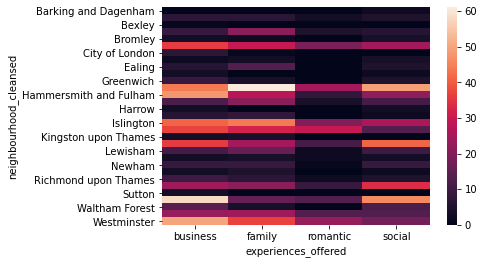

In [133]:
sns.heatmap(experiences_offered)
cmap=sns.cubehelix_palette(as_cmap=True)

In [134]:
"""Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. \
Далее постройте два графика, используя distplot из библиотеки seaborn: \
На первом отобразите исходные распределения цен для каждого типа жилья \
На втором – логарифмированные значения (np.log())"""

'Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Далее постройте два графика, используя distplot из библиотеки seaborn: На первом отобразите исходные распределения цен для каждого типа жилья На втором – логарифмированные значения (np.log())'

In [135]:
room_type_price_core_sql= """
SELECT
    room_type,
    toFloat64OrNull(replaceRegexpAll(price,'[$,]','')) as price
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
limit 100
    """

In [136]:
room_type_price_core= ph.read_clickhouse(query=room_type_price_core_sql, connection=connection_default)

In [137]:
room_type_price_core.head(3)

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0


In [138]:
room_type_price_core.room_type.unique()


array(['Private room', 'Entire home/apt', 'Hotel room'], dtype=object)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


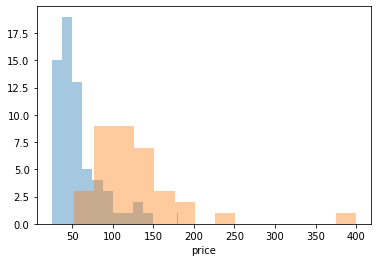

In [139]:
sns.distplot(room_type_price_core.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(room_type_price_core.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(room_type_price_core.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')

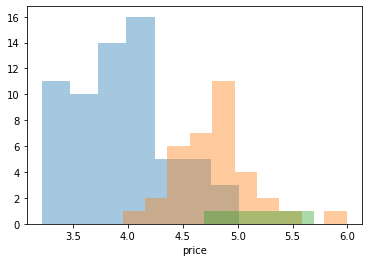

In [140]:
sns.distplot(np.log(room_type_price_core.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(room_type_price_core.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(room_type_price_core.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')